In [1]:
datadir = "data/section 6"
dataset = "pedestrians128x64"
datafile = "%s/%s.tar.gz" % (datadir, dataset)

In [2]:
extractdir = "%s/%s" % (datadir, dataset)

In [3]:
def extract_tar(datafile, extractdir):
    try:
        import tarfile
    except ImportError:
        raise ImportError("You do not have tarfile installed. "
                          "Try unzipping the file outside of Python.")

    tar = tarfile.open(datafile)
    tar.extractall(path=extractdir)
    tar.close()
    print("%s successfully extracted to %s" % (datafile, extractdir))

In [4]:
extract_tar(datafile, datadir)

data/section 6/pedestrians128x64.tar.gz successfully extracted to data/section 6


In [5]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

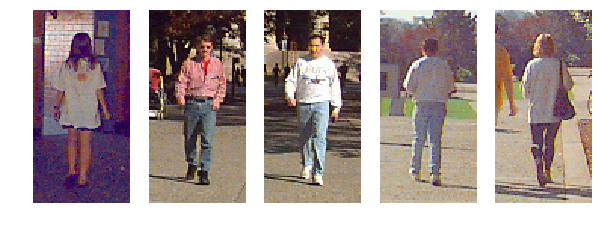

In [6]:
plt.figure(figsize=(10, 6))
for i in range(5):
    filename = "%s/per0010%d.ppm" % (extractdir, i)
    img = cv2.imread(filename)

    plt.subplot(1, 5, i + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

In [7]:
win_size = (48, 96)
block_size = (16, 16)
block_stride = (8, 8)
cell_size = (8, 8)
num_bins = 9
hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, num_bins)

In [8]:
import numpy as np
import random
random.seed(42)
X_pos = []
for i in random.sample(range(900), 400):
    filename = "%s/per%05d.ppm" % (extractdir, i)
    img = cv2.imread(filename)
    if img is None:
        print('Could not find image %s' % filename)
        continue
    X_pos.append(hog.compute(img, (64, 64)))

Could not find image data/section 6/pedestrians128x64/per00000.ppm


In [9]:
X_pos = np.array(X_pos, dtype=np.float32)
y_pos = np.ones(X_pos.shape[0], dtype=np.int32)
X_pos.shape, y_pos.shape

((399, 1980, 1), (399,))

In [10]:
negset = "pedestrians_neg"
negfile = "%s/%s.tar.gz" % (datadir, negset)
negdir = "%s/%s" % (datadir, negset)
extract_tar(negfile, datadir)

data/section 6/pedestrians_neg.tar.gz successfully extracted to data/section 6


In [11]:
import os
hroi = 128
wroi = 64
X_neg = []
for negfile in os.listdir(negdir):
    filename = '%s/%s' % (negdir, negfile)
    img = cv2.imread(filename)
    img = cv2.resize(img, (512, 512))
    for j in range(5):
        rand_y = random.randint(0, img.shape[0] - hroi)
        rand_x = random.randint(0, img.shape[1] - wroi)
        roi = img[rand_y:rand_y + hroi, rand_x:rand_x + wroi, :]
        X_neg.append(hog.compute(roi, (64, 64)))

In [12]:
X_neg = np.array(X_neg, dtype=np.float32)
y_neg = -np.ones(X_neg.shape[0], dtype=np.int32)
X_neg.shape, y_neg.shape

((250, 1980, 1), (250,))

In [13]:
X = np.concatenate((X_pos, X_neg))
y = np.concatenate((y_pos, y_neg))

In [14]:
from sklearn import model_selection as ms
X_train, X_test, y_train, y_test = ms.train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [15]:
def train_svm(X_train, y_train):
    svm = cv2.ml.SVM_create()
    svm.train(X_train, cv2.ml.ROW_SAMPLE, y_train)
    return svm

In [16]:
def score_svm(svm, X, y):
    from sklearn import metrics
    _, y_pred = svm.predict(X)
    return metrics.accuracy_score(y, y_pred)

In [17]:
svm = train_svm(X_train, y_train)

In [18]:
score_svm(svm, X_train, y_train)

1.0

In [19]:
score_svm(svm, X_test, y_test)

0.6461538461538462

In [20]:
score_train = []
score_test = []
for j in range(3):
    svm = train_svm(X_train, y_train)
    score_train.append(score_svm(svm, X_train, y_train))
    score_test.append(score_svm(svm, X_test, y_test))
    
    _, y_pred = svm.predict(X_test)
    false_pos = np.logical_and((y_test.ravel() == -1), (y_pred.ravel() == 1))
    if not np.any(false_pos):
        print('done')
        break
    X_train = np.concatenate((X_train, X_test[false_pos, :]), axis=0)
    y_train = np.concatenate((y_train, y_test[false_pos]), axis=0)

done


In [21]:
score_train

[1.0, 1.0]

In [22]:
score_test

[0.6461538461538462, 1.0]

In [23]:
img_test = cv2.imread('data/section 6/pedestrian_test.jpg')

In [24]:
stride = 16
found = []
for ystart in np.arange(0, img_test.shape[0], stride):
    for xstart in np.arange(0, img_test.shape[1], stride):
        if ystart + hroi > img_test.shape[0]:
            continue
        if xstart + wroi > img_test.shape[1]:
            continue
        roi = img_test[ystart:ystart + hroi, xstart:xstart + wroi, :]
        feat = np.array([hog.compute(roi, (64, 64))])
        _, ypred = svm.predict(feat)
        if np.allclose(ypred, 1):
            found.append((ystart, xstart, hroi, wroi))

In [25]:
hog = cv2.HOGDescriptor(win_size, block_size, cell_size, block_stride, num_bins)

In [26]:
rho, _, _ = svm.getDecisionFunction(0)
sv = svm.getSupportVectors()
hog.setSVMDetector(np.append(sv[0, :].ravel(), rho))

In [27]:
hogdef = cv2.HOGDescriptor()

In [28]:
hogdef.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

In [29]:
found, _ = hogdef.detectMultiScale(img_test)

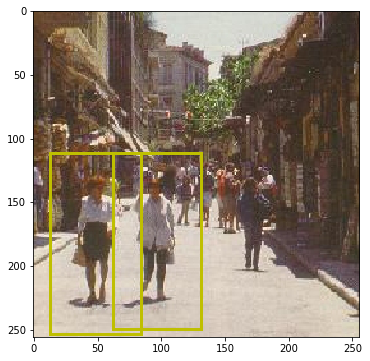

In [30]:
from matplotlib import patches
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.imshow(cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB))

for f in found:
    ax.add_patch(patches.Rectangle((f[0], f[1]), f[2], f[3], color='y', linewidth=3, fill=False))
plt.savefig('detected.png')